# Lesson 0024 - MNIST Classification Convolutional Neural Network (VII)
In the last [lesson](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0023_mnist_classification_convolutional_neural_network_6.ipynb), we introduced dropout to our network and gained a little extra in performance, but we realized, that using $512$ filters in $2$ convolutional layers is enough to learn the complete training set.<br>
This time, we try another architecture: we will use $3$ convolutional layers of $64$ filters each, one layer of max pooling, and one dropout layer at the end.<br>
We do this, because we assume, that the first convolutional layer learns concepts like circles or diagonals or horizontal lines as we can see in [lesson 0019](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0019_mnist_classification_convolutional_neural_network_2.ipynb). We assume the second and third layer consecutively combine these data to higher abstractions.<br>
We begin with stealing code from [lesson 0023](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0023_mnist_classification_convolutional_neural_network_6.ipynb):

In [1]:
import tensorflow as tf

tf.set_random_seed( 1234567890 )

print( tf.__version__ )

1.13.1


In [2]:
( train_x, train_y ),( test_x, test_y ) = tf.keras.datasets.mnist.load_data()

In [3]:
import numpy as np

np.random.seed( 1234567890 )

print( np.__version__ )

1.16.2


In [4]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


In [5]:
mu = np.mean( train_x )

sigma = np.std( train_x )



train_x = ( train_x - mu ) / sigma

test_x = ( test_x - mu ) / sigma

In [6]:
train_y_2 = np.zeros( shape = [ 60000, 10 ] )

test_y_2 = np.zeros( shape = [ 10000, 10 ] )




for i in range( 60000 ):
    
    train_y_2[ i, train_y[ i ] ] = 1.0
    
    
for i in range( 10000 ):
    
    test_y_2[ i, test_y[ i ] ] = 1.0
    




train_y = train_y_2

test_y = test_y_2

Now we create the new architecture. We introduce $3$ consecutive convolutional layers of $64$ filters each.<br>
The first layer will turn the input image into $64$ $24*24$ pictures, the second layer will transform this into $64$ $20*20$ images, and the third layer will transform this into $64$ $16*16$ images.<br>
Then, we have a max pooling layer of $2*2$ filter size and $\left( 2, 2\right)$ strides.<br>
We then flatten these data, then we introduce a dropout layer, and finally feed this into the output layer.<br>
We train this model for $200000$ iterations with a learning rate of $0.0001$ on $100$ randomly drawn training data.<br>
During training, the dropout rate will be set to $0.8$, during evalution it will be set to $0$.

In [7]:
x_tf = tf.placeholder( tf.float32, shape = [ None, 28, 28, 1 ] )

y_tf = tf.placeholder( tf.float32, shape = [ None, 10 ] )

dropout_rate = tf.placeholder( tf.float32 )




conv1 = tf.layers.conv2d( x_tf, filters = 64, kernel_size = [ 5, 5 ], name = 'conv1' )

conv2 = tf.layers.conv2d( conv1, filters = 64, kernel_size = [ 5, 5 ] )

conv3 = tf.layers.conv2d( conv2, filters = 64, kernel_size = [ 5, 5 ] )

max1 = tf.layers.max_pooling2d( conv3, pool_size = [ 2, 2 ], strides = [ 2, 2 ] )

flat = tf.layers.flatten( max1 )

dropout = tf.layers.dropout( flat, rate = dropout_rate )





W_tf = tf.Variable( tf.truncated_normal( [ 4096, 10 ] ) )

b_tf = tf.Variable( tf.truncated_normal( [ 10 ] ) )

output = tf.nn.leaky_relu( tf.matmul( dropout, W_tf ) + b_tf )




cross_entropy = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2( logits = output, labels = y_tf ) )




gd = tf.train.GradientDescentOptimizer( 0.0001 ).minimize( cross_entropy )



hit = tf.equal( tf.argmax( output, 1 ), tf.argmax( y_tf, 1 ) )



accuracy = 100 * tf.reduce_mean( tf.cast( hit, tf.float32 ) )

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dropout instead.


In [8]:
config = tf.ConfigProto()

config.gpu_options.allow_growth = True

sess = tf.Session(config=config)

In [9]:
progress_train = []

progress_train_current = []

progress_test = []

progress_iterations = []

test_performance_buffer = []

train_performance_buffer = []






train_x_r = np.reshape( train_x, newshape = [ 60000, 28, 28, 1 ] )

test_x_r = np.reshape( test_x, newshape = [ 10000, 28, 28, 1 ] )
 
    
    
sess.run( tf.global_variables_initializer() )
        
for i in range( 200000 ):
                
    random_integers = np.random.choice( range( 60000 ), 100, replace = False )
                
    local_x = train_x[ random_integers, :, : ]
    
    local_y = train_y[ random_integers, : ]
    
    local_x = np.reshape( local_x, newshape = [ 100,28, 28, 1 ] )
        
    sess.run( gd, feed_dict = { x_tf : local_x, y_tf : local_y, dropout_rate : 0.8 } )
    
    if( ( i % 100 ) == 0 ):
        
        for j in range(60):
            
            train_performance_buffer.append( 
                sess.run( accuracy, feed_dict = { x_tf : train_x_r[ ( j * 1000 ) : ( ( j + 1 ) * 1000 ), :, :, : ],
                                                 y_tf : train_y[ ( j * 1000 ) : ( ( j + 1 ) * 1000 ), : ], 
                                                dropout_rate : 0.0 } ) )
            
        progress_train.append( np.mean( train_performance_buffer ) )
        
        train_performance_buffer = []
        
        for j in range(10):
            
            test_performance_buffer.append( 
                sess.run( accuracy, feed_dict = { x_tf : test_x_r[ ( j * 1000 ) : ( ( j + 1 ) * 1000 ), :, :, : ],
                                                 y_tf : test_y[ ( j * 1000 ) : ( ( j + 1 ) * 1000 ), : ],
                                                dropout_rate : 0.0 } ) )
            
        progress_test.append( np.mean( test_performance_buffer ) )
        
        test_performance_buffer = []
        
        progress_train_current.append( sess.run( accuracy, feed_dict = { x_tf : local_x, y_tf : local_y, 
                                                                        dropout_rate : 0.0 } ) )
        
        progress_iterations.append( i )

Text(0, 0.5, 'Accuracy (%)')

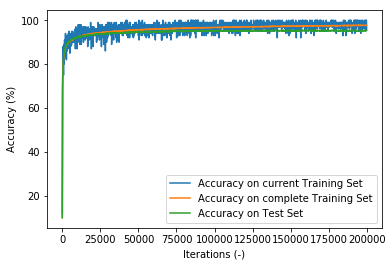

In [10]:
plt.plot( progress_iterations, progress_train_current, label = 'Accuracy on current Training Set' )

plt.plot( progress_iterations, progress_train, label = 'Accuracy on complete Training Set' )

plt.plot( progress_iterations, progress_test, label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'Accuracy (%)' )

Text(0, 0.5, 'Accuracy (%)')

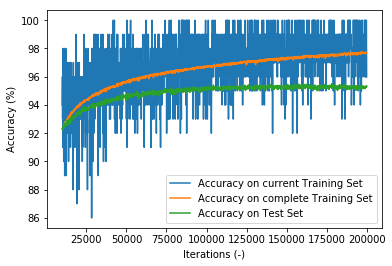

In [11]:
plt.plot( progress_iterations[ 100 : 2000 ], progress_train_current[ 100 : 2000 ], 
         label = 'Accuracy on current Training Set' )

plt.plot( progress_iterations[ 100 : 2000 ], progress_train[ 100 : 2000 ], label = 'Accuracy on complete Training Set' )

plt.plot( progress_iterations[ 100 : 2000 ], progress_test[ 100 : 2000 ], label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'Accuracy (%)' )

Text(0, 0.5, 'Accuracy (%)')

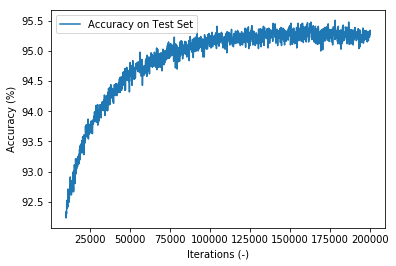

In [12]:
plt.plot( progress_iterations[ 100 : 2000 ], progress_test[ 100 : 2000 ], label= 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'Accuracy (%)' )

In [13]:
saver = tf.train.Saver()

saver.save( sess, 
           "C:\\Users\\rhopi\\OneDrive\\Desktop\\python dev\\github\\lesson_0024\\model\\convolutional_neural_network_64_64_64_dropout" )

sess.close()

In comparison to [lesson 0019](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0019_mnist_classification_convolutional_neural_network_2.ipynb), this model performs worse, even though it has one more convolutional layer.<br>
Therefore, we stop exploring convolutional neural networks for the MNIST data set, because if adding additional layers does not improve the performance, then the model from [lesson 0023](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0023_mnist_classification_convolutional_neural_network_6.ipynb) is the best model for the MNIST dataset, we can build right now.<br>
Class dismissed.